# Downsample the data based on userid and create event lables for frequency features generation
- Because I am running on my local computer, and the play log file is too large (9.5G), so I need to only choose a fraction of all the users.
- Then we create 'P', 'D' and 'S' labels to represent play, download and search events.
- Next step we will create frequency features based these event labels for each userid.

In [2]:
# use shell script to count unique id (large file, slow)
import os
cmd="""
export LC_CTYPE=C 
export LANG=C
# get uid field| sort | count unique ids | strip blank spaces | output to file
cat data/play/all_play_log| cut -f1 -d$'\t'| sort | uniq -c | sed -e 's/^ *//g;s/ *$//g'> data/uid_count.csv
"""
os.system(cmd)

2

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('data/uid_count.csv', sep='\s+', names=['count', 'uid'])

In [3]:
df.head(10)

,count,uid
0,46067,0
1,17,100077577
2,39,100077978
3,86,100087237
4,63,100102865
5,4,100107633
6,33,100139083
7,92,100202712
8,15,100223381
9,3,100227405


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305209 entries, 0 to 305208
Data columns (total 2 columns):
count    305209 non-null int64
uid      305209 non-null int64
dtypes: int64(2)
memory usage: 4.7 MB


In [5]:
df.describe()

,count,uid
count,305209.000000,3.052090e+05
mean,52.267030,1.672622e+08
std,1710.652118,1.102381e+07
min,1.000000,0.000000e+00
25%,6.000000,1.679833e+08
50%,19.000000,1.684135e+08
75%,45.000000,1.687403e+08
max,527578.000000,1.692623e+08


In [6]:
df.sort_values(['count'], ascending=[0]).head(50)

,count,uid
168192,527578,1685126
303165,436606,1791497
303673,369985,37025504
304739,348174,751824
304063,320325,497685
116,185778,1062806
304699,131211,736305
303149,53500,1749320
0,46067,0
303976,35373,46532274


## Remove the robot users and outliers

In [7]:
print('the total number of users is: ', len(df['uid']))

the total number of users is:  305209


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

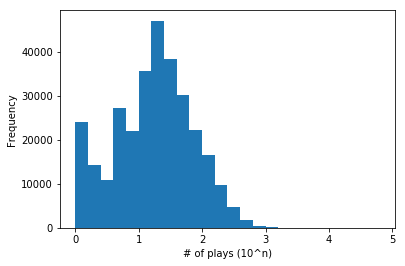

In [9]:
np.log10(df['count']).plot.hist(bins=np.arange(0, 5, 0.2))
plt.xlabel('# of plays (10^n)')

In [10]:
count_threshold = np.percentile(df['count'], 99.9)
count_threshold

967.79200000001583

In [11]:
id_list = np.array(df['uid'][df['count'] < count_threshold].dropna())

In [12]:
print('# of users after removing outliers: ', len(id_list))

# of users after removing outliers:  304903


## Downsampling on userid level for play, down and search

- ds_ratio is the fraction we want to keep

In [13]:
np.random.seed = 1
ds_ratio = 0.1
id_list_ds = set(id_list[np.random.random(id_list.shape) < ds_ratio])

In [14]:
print('# of uses after downsampling:', len(id_list_ds))

# of uses after downsampling: 30558


In [15]:
# function to convert the date to datetime format
import datetime
def convert_date(date):
    date = str(date).strip()
    try:
        year = int(date[0:4])
        month = int(date[4, 6])
        day = int(date[6:])
        return datetime.date(year, month, day)
    except:
        return None

In [16]:
import csv

input_files = ['data/play/all_play_log', 'data/down/all_down_log', 'data/search/all_search_log']
output_files = ['data/play/play.csv', 'data/down/down.csv', 'data/search/search.csv']
input_keyList_play = ['uid', 'device', 'song_id', 'song_type', 'song_name', 'singer', 'play_time', 'song_len', 'paid_flag', 'date']
output_keyList_play = ['uid', 'device', 'song_id', 'play_time', 'song_len', 'date']
input_keyList_down = ['uid', 'device', 'song_id', 'song_name', 'singer', 'paid_flag', 'date']
output_keyList_down = ['uid', 'device', 'song_id', 'date']
input_keyList_search = ['uid', 'device', 'time_stamp', 'search_query', 'date']
output_keyList_search = ['uid', 'device', 'date']
input_keyLists = []
input_keyLists.append(input_keyList_play)
input_keyLists.append(input_keyList_down)
input_keyLists.append(input_keyList_search)
output_keyLists = []
output_keyLists.append(output_keyList_play)
output_keyLists.append(output_keyList_down)
output_keyLists.append(output_keyList_search)

# print when every millon lines are processed 

line = 0

for i in range(1):
    
    with open(input_files[i], 'r', encoding='latin-1') as fin, open(output_files[i], 'w') as fout:
        csvin = csv.DictReader(fin, delimiter='\t', fieldnames=input_keyLists[i], quoting=csv.QUOTE_NONE)
        csvout = csv.writer(fout, delimiter=',')
        # write header first
        csvout.writerow(output_keyLists[i])
        for row in csvin:
            #print ([str(row[key]).strip() for key in output_keyLists[i]])
            line += 1
            if (line % 1000000) == 0:
                print(input_files[i], '# of lines processed: ', line)
            try:
                int(row['uid'])
            except:
                continue
            if int(row['uid']) in id_list_ds:
               # row['date'] = convert_date(row['date'])
                #if row['date'] != None:
                 csvout.writerow([str(row[key]).strip() for key in output_keyLists[i]])


data/play/all_play_log # of lines processed:  1000000
data/play/all_play_log # of lines processed:  2000000
data/play/all_play_log # of lines processed:  3000000
data/play/all_play_log # of lines processed:  4000000
data/play/all_play_log # of lines processed:  5000000
data/play/all_play_log # of lines processed:  6000000
data/play/all_play_log # of lines processed:  7000000
data/play/all_play_log # of lines processed:  8000000
data/play/all_play_log # of lines processed:  9000000
data/play/all_play_log # of lines processed:  10000000
data/play/all_play_log # of lines processed:  11000000
data/play/all_play_log # of lines processed:  12000000
data/play/all_play_log # of lines processed:  13000000
data/play/all_play_log # of lines processed:  14000000
data/play/all_play_log # of lines processed:  15000000
data/play/all_play_log # of lines processed:  16000000
data/play/all_play_log # of lines processed:  17000000
data/play/all_play_log # of lines processed:  18000000
data/play/all_play_

## Merge the play, down and search files into one event file and create labels 'P', 'D' and 'S' to represent them.

In [58]:
output_file = 'data/event.ds'
output_keyList = ['uid', 'event', 'song_id', 'date']

with open('data/play/play.csv', 'r') as f_play, open('data/down/down.csv', 'r') as f_down,\
open('data/search/search.csv', 'r') as f_search, open('data/event.ds', 'w') as f_event:
    csv_play = csv.DictReader(f_play, delimiter=',')
    csv_down = csv.DictReader(f_down, delimiter=',')
    csv_search = csv.DictReader(f_search, delimiter=',')
    csvout = csv.writer(f_event, delimiter=',')
    # write the header first
    csvout.writerow(output_keyList)
    print('start processing play..')
    for row in csv_play:
        row['event'] = 'P'
        csvout.writerow([row[key] for key in output_keyList])
    print('processing play done..')
    print('start processing down')
    for row in csv_down:
        row['event'] = 'D'
        csvout.writerow([row[key] for key in output_keyList])
    print('processing down done..')
    print('start processing search..')
    for row in csv_search:
        row['event'] = 'S'
        csvout.writerow([row.get(key, ' ') for key in output_keyList])
    

start processing play..
processing play done..
start processing down
processing down done..
start processing search..


KeyError: 'song_id'